## Flow TSNMF Model

In [4]:
DATA_PATH = '../RunRunGender/'

In [2]:
from tsnmf_edit import TSNMF
from sklearn.feature_extraction.text import TfidfTransformer
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import joblib
import matplotlib as mpl
from scipy.sparse import load_npz
import ujson as json
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize, MinMaxScaler

# para MinMax Scaler
sup_min_bubble_size = 0
sup_max_bubble_size = 70

sns.set(style='ticks', palette='magma', context='notebook', font='Linux Biolinum O')
#%config InlineBackend.figure_format = 'retina'
%matplotlib inline

def normalize_dataframe_rows(df):
    df = pd.DataFrame(normalize(df, norm='l1'), index=df.index, columns=df.columns)
    return df

def plot_component(column, **kwargs):
    df = kwargs.pop('data')
    ax = plt.gca()
    #urban_context.plot(ax=ax, facecolor='#efefef', edgecolor='#cfcfcf')
    #highways.plot(ax=ax, color='#333333', linewidth=1)
    #primary.plot(ax=ax, color='orange', linewidth=1)
    #cycleways.plot(ax=ax, color='lime', linewidth=1)

    scaler = kwargs.pop('scaler', None)
    sizes = scaler.transform(np.sqrt(df[column].values.reshape(-1, 1)))
    ax.scatter(df.geometry.x, df.geometry.y, s=sizes, color='#4B0082', alpha=0.5, zorder=20)
    plt.axis('off')
    plt.axis('equal')

In [3]:
RM_map = gpd.read_file('maps/R13/LIMITE_URBANO_CENSAL_C17.shp')
RM_map['COMUNA'] = RM_map['COMUNA'].astype(np.int)
RM_map = RM_map.set_index('COMUNA')
# Descarto algunas zonas
RM_map2 = RM_map[RM_map.NOM_CATEG=='CIUDAD']
RM_map = RM_map2[~RM_map2.NOM_COMUNA.isin(['CURACAVÍ', 'TILTIL', 'SAN JOSÉ DE MAIPO', 'PIRQUE', 'EL MONTE','TALAGANTE','MELIPILLA', 'LAMPA', 'COLINA', 'CALERA DE TANGO', 'PEÑAFLOR',  'BUIN', 'ISLA DE MAIPO', 'PAINE'])]#rm_map[rm_map.NOM_COMUNA==rm_map.URBANO]
RM_map = RM_map[~RM_map.URBANO.isin(['CIUDAD DEL VALLE'])]
RM_map = gpd.read_file('maps/R13/LIMITE_URBANO_CENSAL_C17.shp')
RM_map['COMUNA'] = RM_map['COMUNA'].astype(np.int)
RM_map = RM_map.set_index('COMUNA')
# Descarto algunas zonas
RM_map2 = RM_map[RM_map.NOM_CATEG=='CIUDAD']
RM_map = RM_map2[~RM_map2.NOM_COMUNA.isin(['CURACAVÍ', 'TILTIL', 'PADRE HURTADO', 'SAN JOSÉ DE MAIPO', 'PIRQUE', 'EL MONTE','TALAGANTE','MELIPILLA', 'COLINA', 'CALERA DE TANGO', 'PEÑAFLOR',  'BUIN', 'ISLA DE MAIPO', 'PAINE'])]#rm_map[rm_map.NOM_COMUNA==rm_map.URBANO]
RM_map = RM_map[~RM_map.URBANO.isin(['CIUDAD DEL VALLE', 'BATUCO', 'CHICAUMA', 'LAMPA'])]
RM_map.boundary.plot(color='black', alpha=0.2)

DriverError: ../RunRunGender/maps/R13/LIMITE_URBANO_CENSAL_C17.shp: No such file or directory

### Importamos datos de las Zonas
Al hacer prediciones del *mnlogit model*, el `input` necesita tener las features correspondientes a la formula utilizada en `EOD_Model_v2.ipynb`.

Por ahora `zone_income` es el único modificable

In [5]:
# Importamos el id, area, la comuna a que pertenece y la geometria
zones = gpd.read_file(DATA_PATH + 'json/urban_zones_2016.json').set_index('ID').to_crs({'init': 'epsg:5361'})
# Distancias entre un origen y un destino
zone_distances = pd.read_csv(DATA_PATH + '2017_results/zone_distances.csv.gz', index_col=['ZonaOrigen', 'ZonaDestino'])
# Periodo en el que se realizo el viaje
zone_matrix = pd.read_json(DATA_PATH + '2017_results/od_matrix_per_zone.json.gz', lines=True)
period_matrices = zone_matrix.groupby(['period', 'origin_zone', 'destination_zone'])['trip_count'].mean()

/home/egraells/hdd_slow/miniconda3/envs/azuki/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [4]:
# Media de Ingresos por Hogar segun zona
zone_income = pd.read_csv(DATA_PATH + '2017_results/zone_income.csv.gz', index_col='Zona')
zone_mindist  =  pd.read_csv(DATA_PATH + '2020_results/mindist_zonahogar.csv', index_col='Zona')

## Importamos las Torres y Waypoints

Al usar *TSNMF* el modelo utiliza los waypoints. En el resultado final la matriz **W** almacena las torres.

In [5]:
# Torres de telefonía ya etiquetadas
towers =  gpd.read_file('2017_results/towers_with_labels.geo.json').set_index('tower')
# Puntos de referencia entre zonas
waypoints = load_npz('2017_results/waypoints_between_zones.npz')
waypoint_index = pd.read_json('2017_results/waypoints_between_zones_index.json.gz', lines=True)
periods = waypoint_index.period.unique()
# Hora peak mañana y tarde
relevant_periods = ['morning_peak_1', 'afternoon_peak']
period = relevant_periods[0] # Para iniciar iteracion

idx_to_tower = dict(zip(range(len(towers)), towers.index.values))
tower_idx = dict(zip(towers.index.values, range(len(towers))))


In [6]:
def find_tower_labels(keys):
    return set(towers[keys].sum(axis=1)
            .pipe(lambda x: x[x > 0].copy())
            .index.values)

rail_keys = find_tower_labels(['within_metro', 'near_surface_metro', 'near_train'])
bus_keys = find_tower_labels(['near_bus_corridor', 'near_bus_routes'])
motorized_keys = find_tower_labels(['near_highways', 'near_primary_streets', 'near_secondary_streets'])
non_motorized_keys = find_tower_labels(['near_cycleways', 'near_pedestrian_streets'])
taxi_keys = find_tower_labels(['near_share_taxi'])

labeled_keys = {
    'bus': bus_keys - (motorized_keys | rail_keys),
    'rail': rail_keys - (bus_keys | motorized_keys),
    #'public': (bus_keys | rail_keys) - (motorized_keys | pedestrian),
    'private': motorized_keys - (bus_keys | taxi_keys | rail_keys | non_motorized_keys),
    'shared_taxi': taxi_keys - (motorized_keys | rail_keys | non_motorized_keys),
    'taxi_public': ((bus_keys | rail_keys ) & taxi_keys) - (motorized_keys | non_motorized_keys)
    #'non_motorized': non_motorized_keys - (bus_keys | rail_keys | motorized_keys | pedestrian)
}

topic_ids = dict(zip(labeled_keys.keys(), range(len(labeled_keys))))

labels = []
for idx in tower_idx:
    #print(idx)
    tower_label = []
    for topic_name, topic_id in topic_ids.items():
        if idx in labeled_keys[topic_name]:
            tower_label.append(topic_id)
    labels.append(tower_label)

#### Se plotean las torres sobre la Región Metropolitana

findfont: Font family ['Linux Biolinum O'] not found. Falling back to DejaVu Sans.


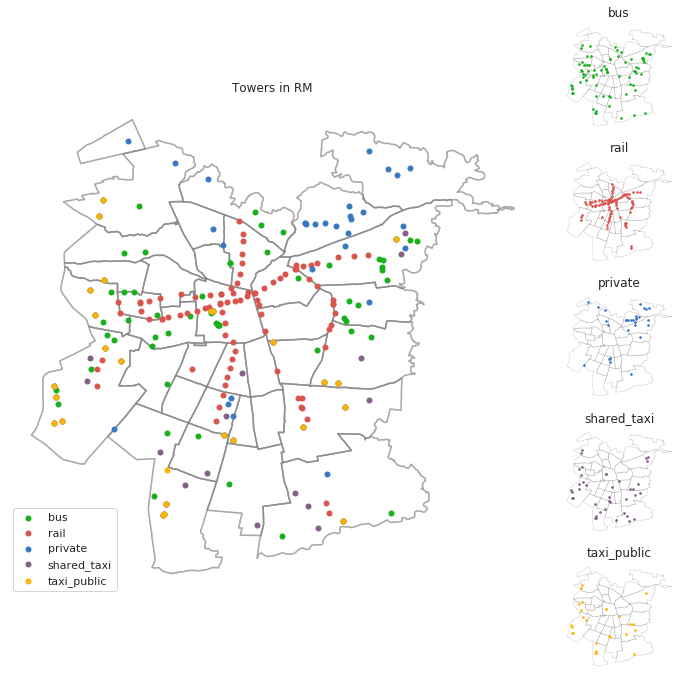

In [7]:
colors = sns.color_palette('Set2', n_colors=len(labeled_keys)+2)
colors = ['green', 'pale red', 'windows blue', 'dusty purple', 'amber']
colors =sns.xkcd_palette(colors)
color_map = dict(zip(labeled_keys.keys(), colors))
plt.figure(figsize=(12,12))
ax1 = plt.subplot2grid((5,5), (0,0), colspan=4, rowspan=5)
ax1.axis('off')
ax_dict = {'all' : ax1}
for i, k in enumerate(labeled_keys.keys()):
    ax_dict[k] = plt.subplot2grid((5,5), (i,4))
    ax_dict[k].axis('off')
    
for label, tower_ids in labeled_keys.items():
    towers.loc[tower_ids].plot(ax=ax1, alpha=1, marker='.', markersize=100, zorder=30, 
            linewidth=1, label=label, color=color_map[label])
    ax1.set_title("Towers in RM")
    ax1.legend(loc=3)
    RM_map.boundary.plot(color='gray', alpha=0.2, ax=ax1)
    
    towers.loc[tower_ids].plot(ax=ax_dict[label], alpha=1, marker='.', markersize=10, zorder=30, 
            linewidth=1, label=label, color=color_map[label])
    ax_dict[label].set_title(label)
    RM_map.boundary.plot(color='black', alpha=0.2, ax=ax_dict[label], linewidth=0.5)


## Se importa el modelo MNLogit
Dicho modelo proviene de `EOD_Model.ipynb`

In [8]:
with open('2020_results/mnlogit_column_names.json') as f:
    mnlogit_column_names = json.load(f)
    
#mnlogit_column_names[-1] = 'shared_taxi'
mnlogit = joblib.load('2020_results/mnlogit_zone_model_instance.joblib.gz')

mnlogit_column_names

['motorized', 'non_motorized', 'public', 'shared_taxi', 'taxi_public']

Ejecutamos la iteración por periodo

Actual period: afternoon_peak
Epoch 05 reached after 0.381 seconds, error: 2215.071165
Epoch 10 reached after 0.732 seconds, error: 2144.296019
Epoch 15 reached after 1.079 seconds, error: 2125.963913
Epoch 20 reached after 1.432 seconds, error: 2122.096909
Epoch 25 reached after 1.780 seconds, error: 2120.745935
Epoch 30 reached after 2.131 seconds, error: 2120.127930
Epoch 35 reached after 2.481 seconds, error: 2119.796490
Epoch 40 reached after 2.833 seconds, error: 2119.588659
Epoch 45 reached after 3.181 seconds, error: 2119.439359
Epoch 50 reached after 3.536 seconds, error: 2119.312903
Epoch 55 reached after 3.885 seconds, error: 2119.189509
Epoch 60 reached after 4.237 seconds, error: 2119.049726
Epoch 65 reached after 4.590 seconds, error: 2118.877166
Epoch 70 reached after 4.947 seconds, error: 2118.664118
Epoch 75 reached after 5.310 seconds, error: 2118.406898
Epoch 80 reached after 5.670 seconds, error: 2118.124417
Epoch 85 reached after 6.026 seconds, error: 2117.852153
E

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


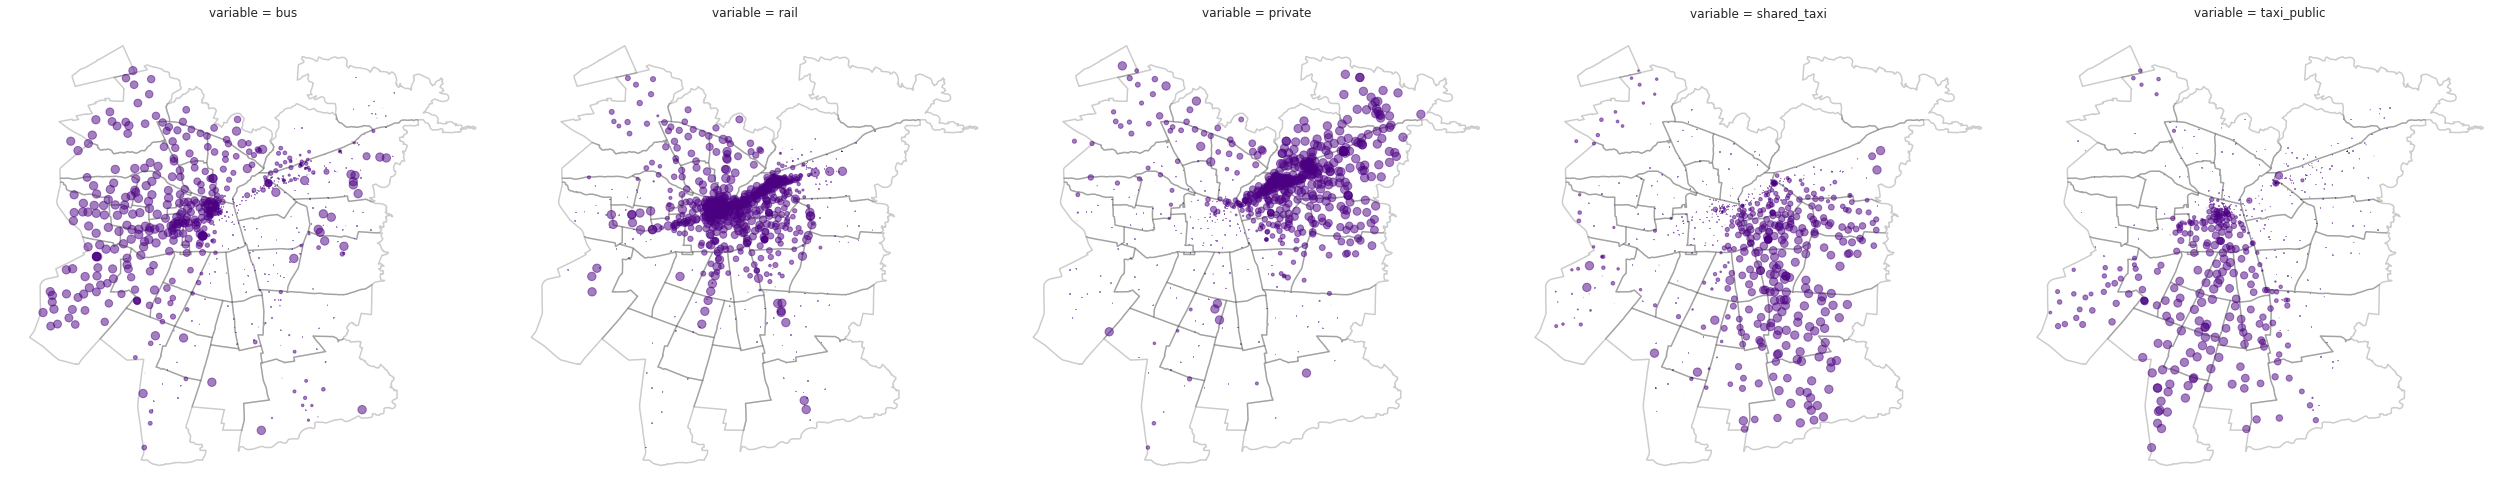

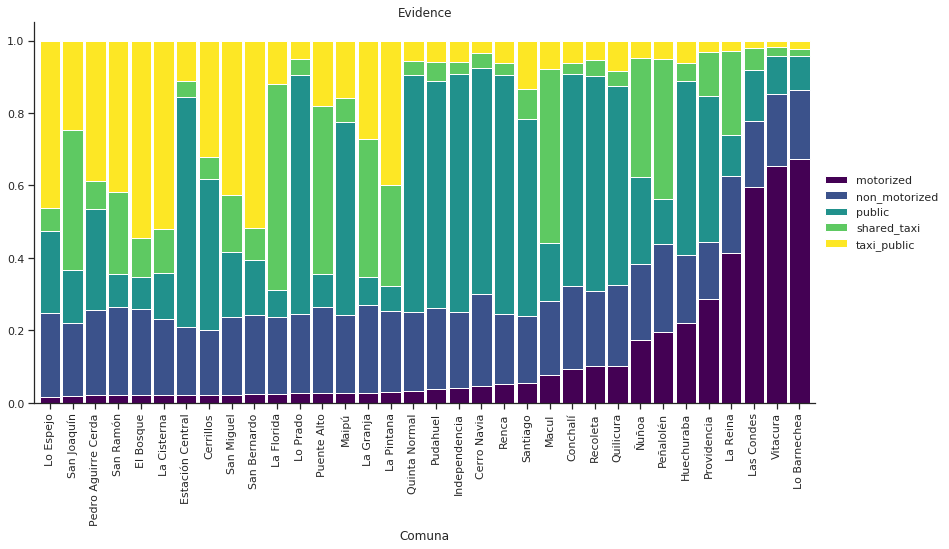

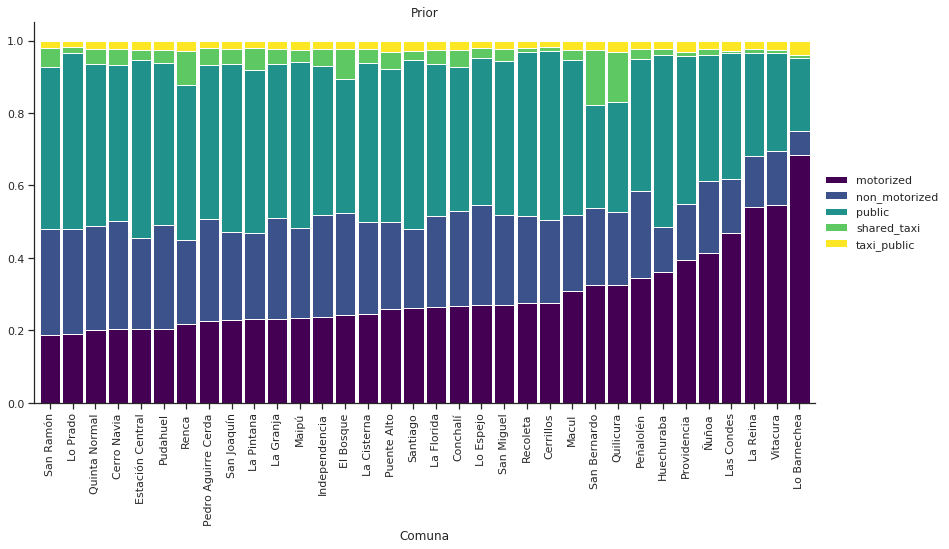

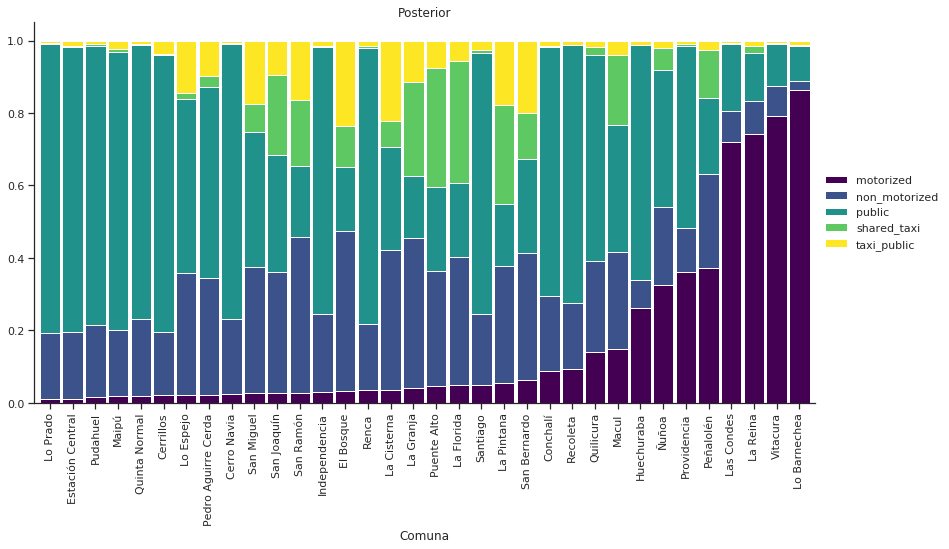

Actual period: afternoon_valley
Epoch 05 reached after 0.552 seconds, error: 2684.369192
Epoch 10 reached after 1.072 seconds, error: 2580.766147
Epoch 15 reached after 1.582 seconds, error: 2543.281727
Epoch 20 reached after 2.103 seconds, error: 2538.085459
Epoch 25 reached after 2.610 seconds, error: 2536.513662
Epoch 30 reached after 3.127 seconds, error: 2535.606330
Epoch 35 reached after 3.635 seconds, error: 2534.989150
Epoch 40 reached after 4.155 seconds, error: 2534.569052
Epoch 45 reached after 4.663 seconds, error: 2534.281728
Epoch 50 reached after 5.182 seconds, error: 2534.081099
Epoch 55 reached after 5.689 seconds, error: 2533.938431
Epoch 60 reached after 6.210 seconds, error: 2533.835249
Epoch 65 reached after 6.718 seconds, error: 2533.758487
Epoch 70 reached after 7.241 seconds, error: 2533.700036
Epoch 75 reached after 7.752 seconds, error: 2533.655189
Epoch 80 reached after 8.275 seconds, error: 2533.619713
Epoch 85 reached after 8.786 seconds, error: 2533.591270

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


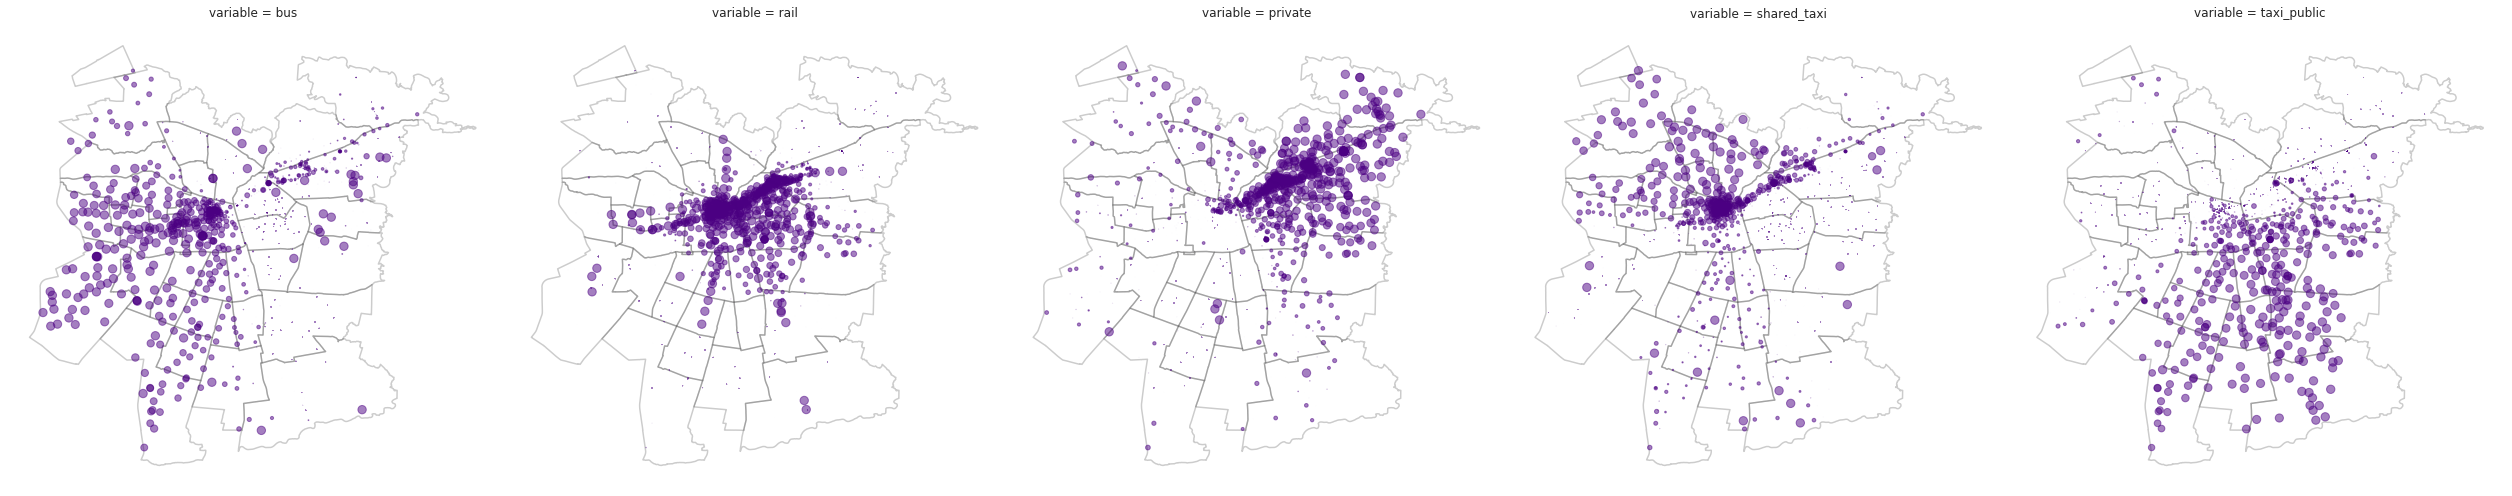

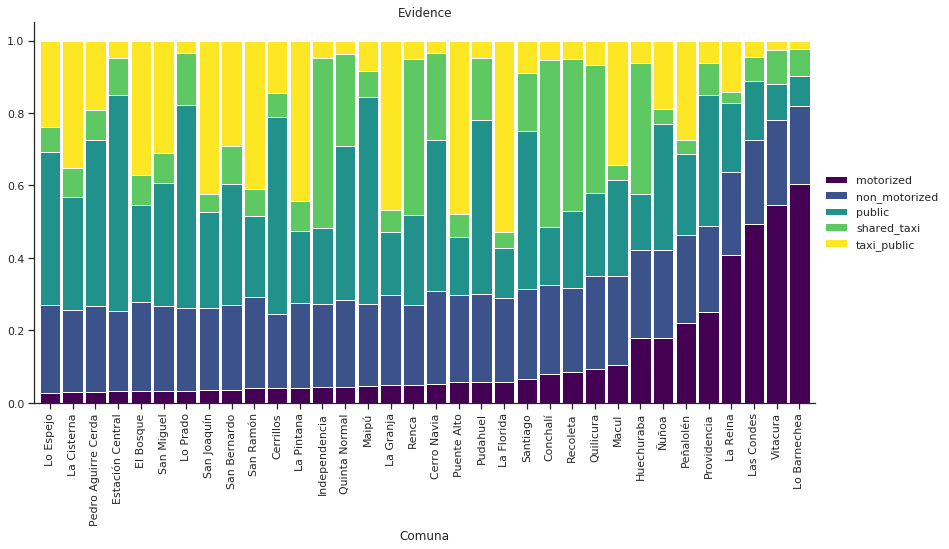

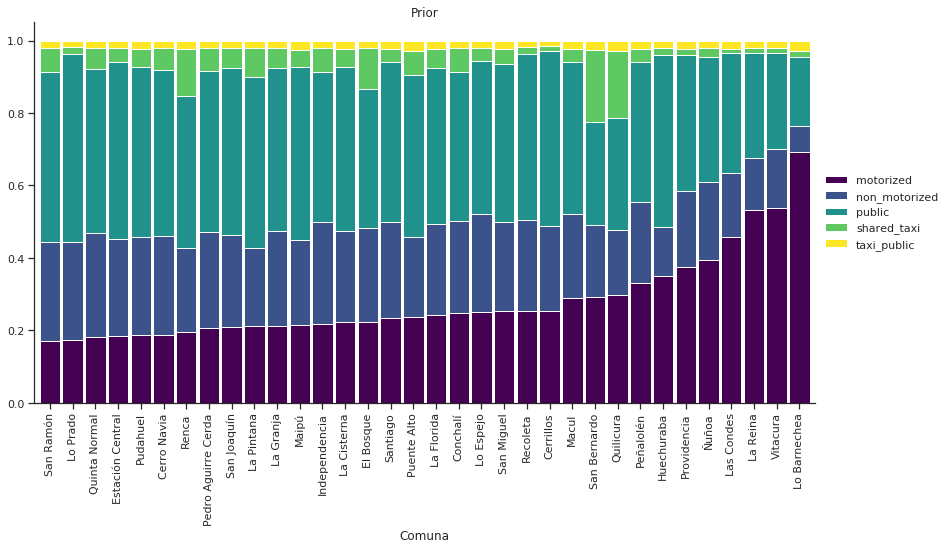

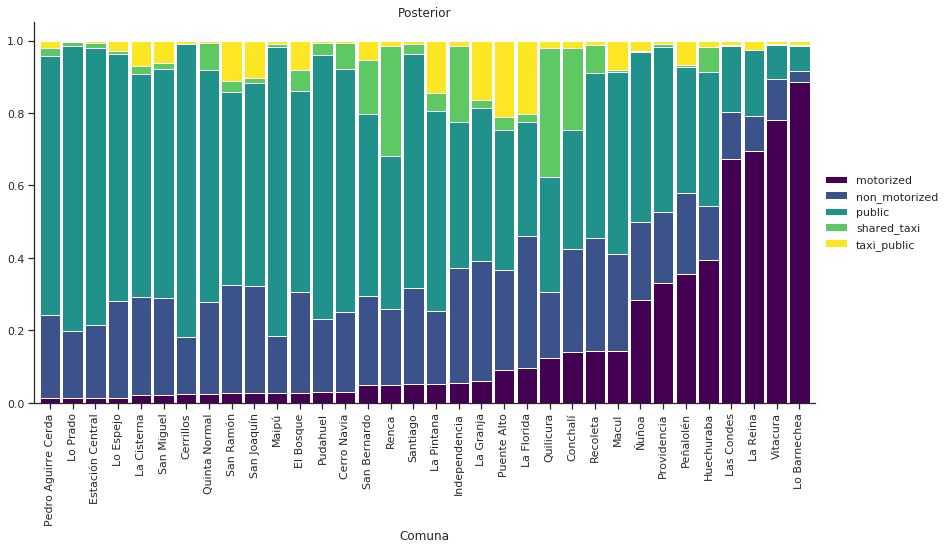

Actual period: morning_peak_1
Epoch 05 reached after 0.206 seconds, error: 1655.217781
Epoch 10 reached after 0.398 seconds, error: 1622.499485
Epoch 15 reached after 0.587 seconds, error: 1610.673680
Epoch 20 reached after 0.777 seconds, error: 1607.142544
Epoch 25 reached after 0.966 seconds, error: 1605.197782
Epoch 30 reached after 1.156 seconds, error: 1604.176295
Epoch 35 reached after 1.349 seconds, error: 1603.783037
Epoch 40 reached after 1.539 seconds, error: 1603.615244
Epoch 45 reached after 1.728 seconds, error: 1603.526824
Epoch 50 reached after 1.919 seconds, error: 1603.472938
Epoch 55 reached after 2.108 seconds, error: 1603.436724
Epoch 60 reached after 2.299 seconds, error: 1603.411156
Epoch 65 reached after 2.492 seconds, error: 1603.392446
Epoch 70 reached after 2.685 seconds, error: 1603.378022
Epoch 75 reached after 2.879 seconds, error: 1603.366373
Epoch 80 reached after 3.074 seconds, error: 1603.356798
Epoch 85 reached after 3.270 seconds, error: 1603.348911
E

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


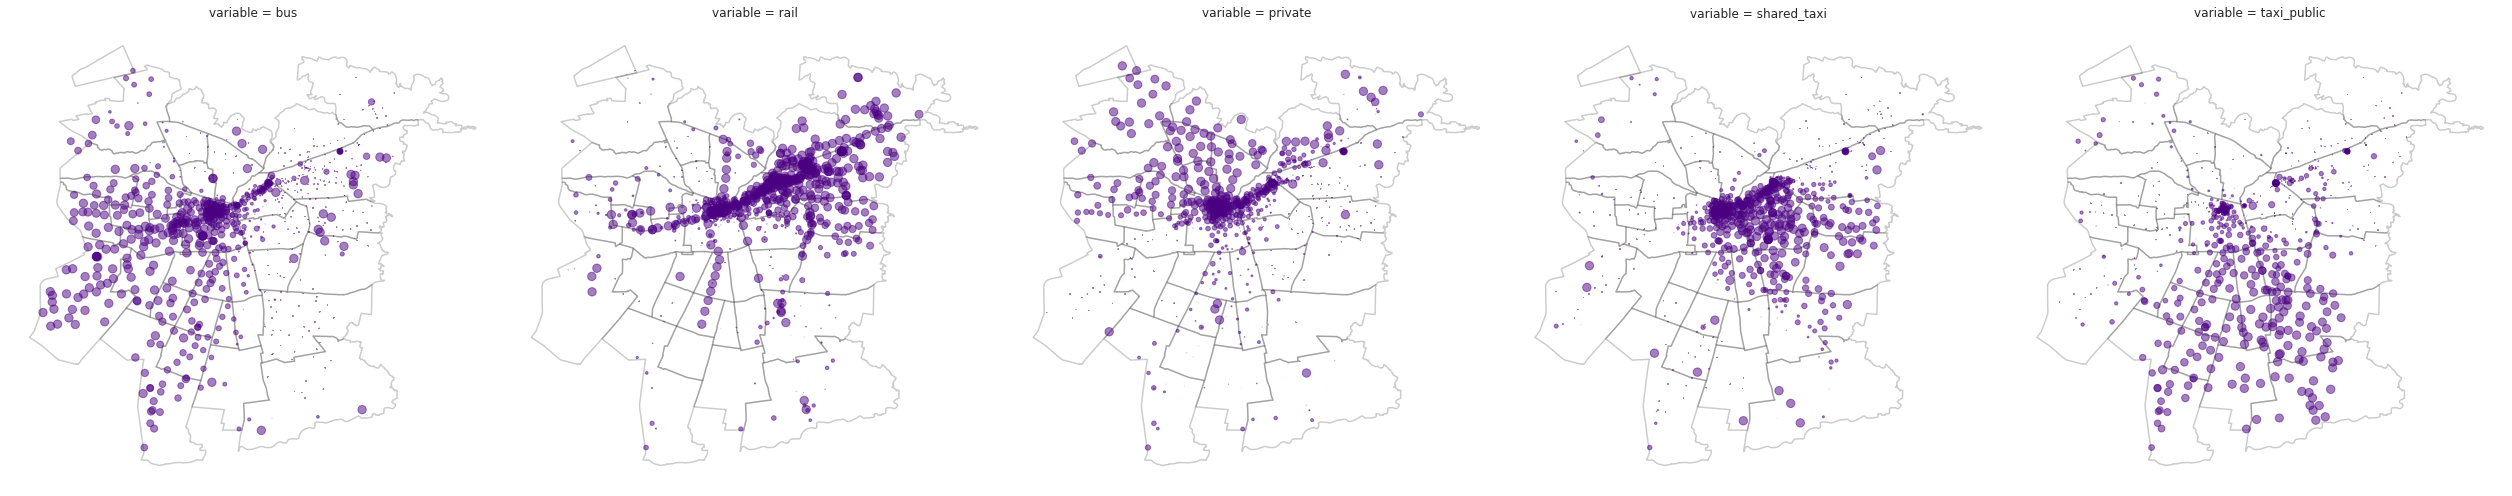

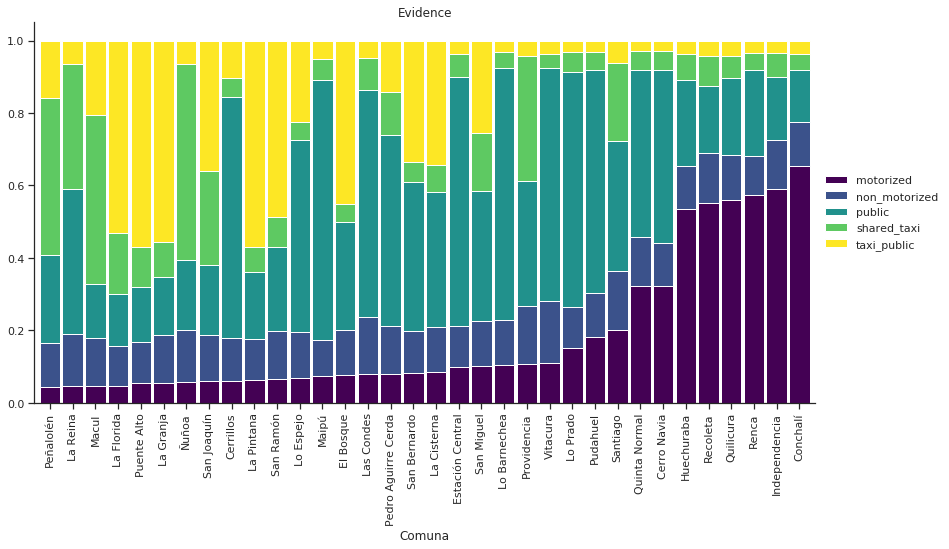

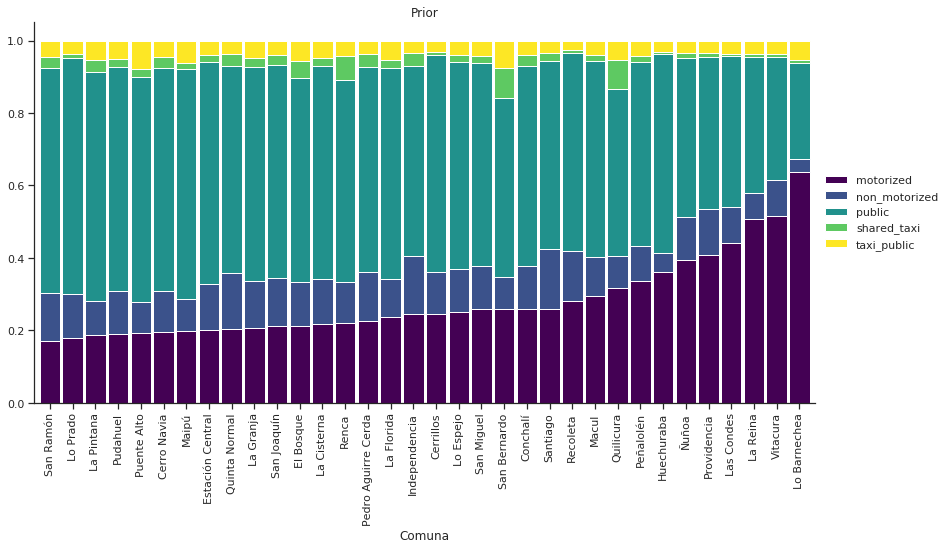

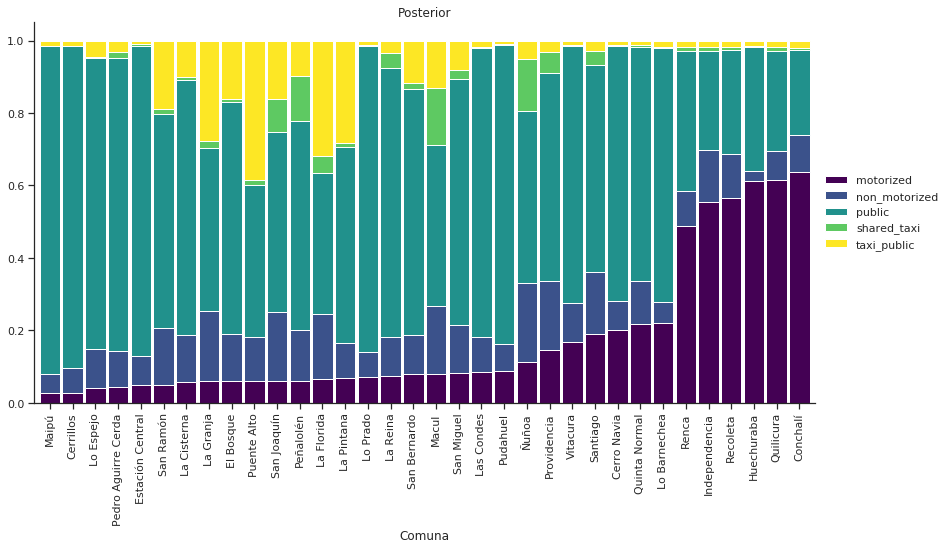

Actual period: morning_peak_2
Epoch 05 reached after 0.240 seconds, error: 1650.381704
Epoch 10 reached after 0.464 seconds, error: 1614.342978
Epoch 15 reached after 0.685 seconds, error: 1601.626360
Epoch 20 reached after 0.909 seconds, error: 1599.731065
Epoch 25 reached after 1.130 seconds, error: 1599.253990
Epoch 30 reached after 1.354 seconds, error: 1599.067486
Epoch 35 reached after 1.571 seconds, error: 1598.968758
Epoch 40 reached after 1.789 seconds, error: 1598.900118
Epoch 45 reached after 2.003 seconds, error: 1598.840086
Epoch 50 reached after 2.221 seconds, error: 1598.775533
Epoch 55 reached after 2.436 seconds, error: 1598.694408
Epoch 60 reached after 2.655 seconds, error: 1598.583317
Epoch 65 reached after 2.873 seconds, error: 1598.427325
Epoch 70 reached after 3.095 seconds, error: 1598.213805
Epoch 75 reached after 3.317 seconds, error: 1597.942295
Epoch 80 reached after 3.543 seconds, error: 1597.631600
Epoch 85 reached after 3.766 seconds, error: 1597.330882
E

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


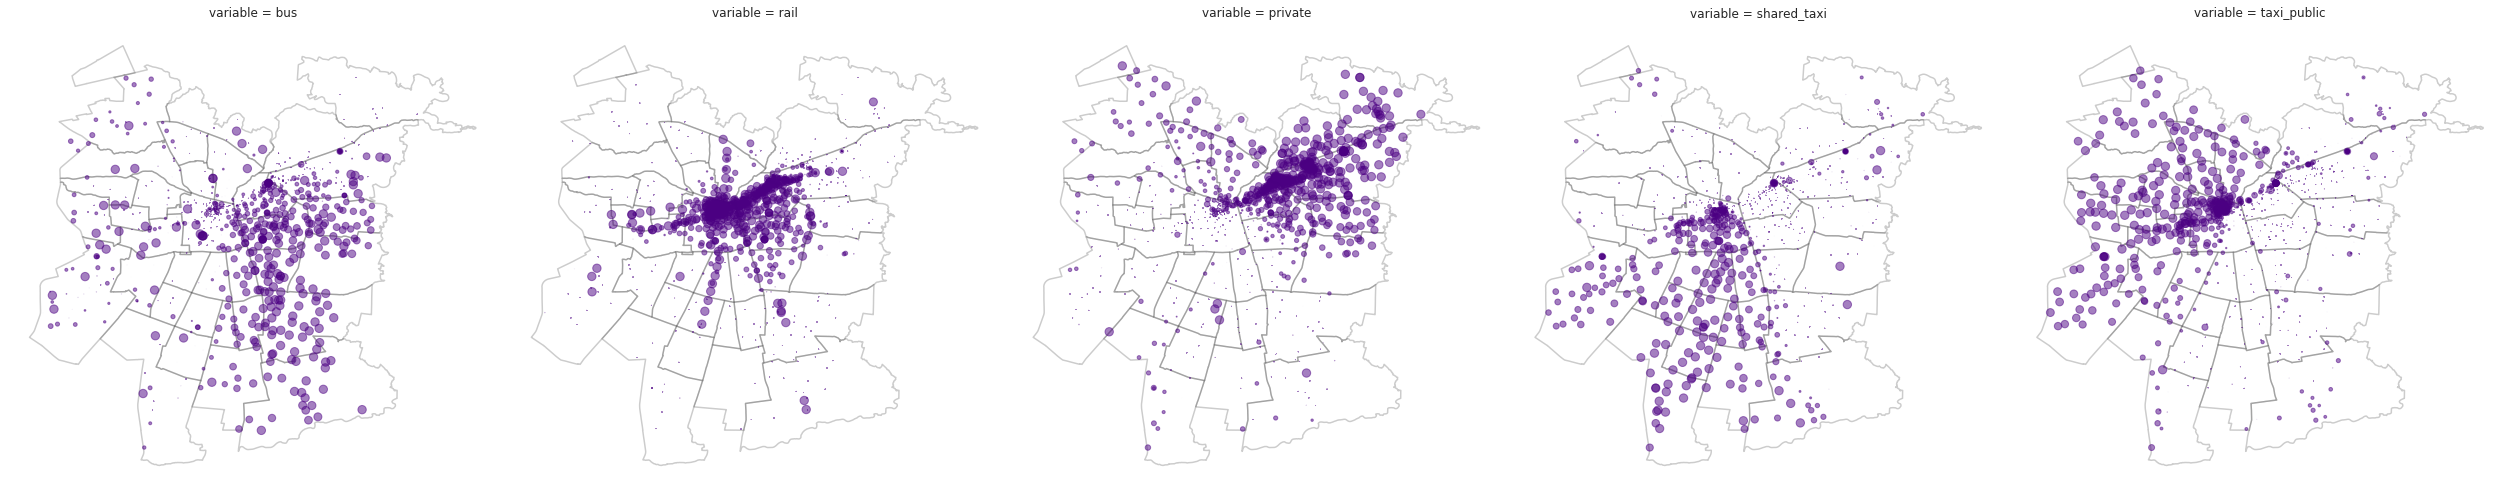

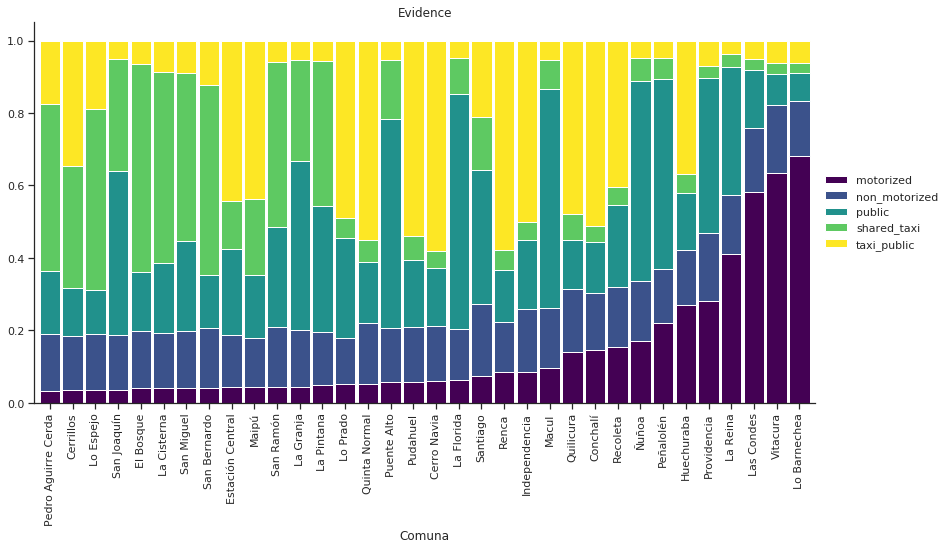

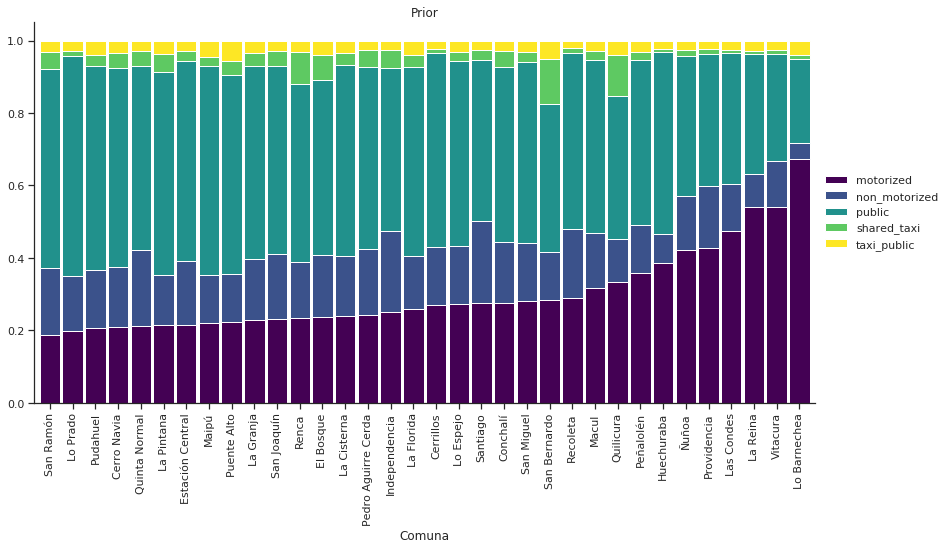

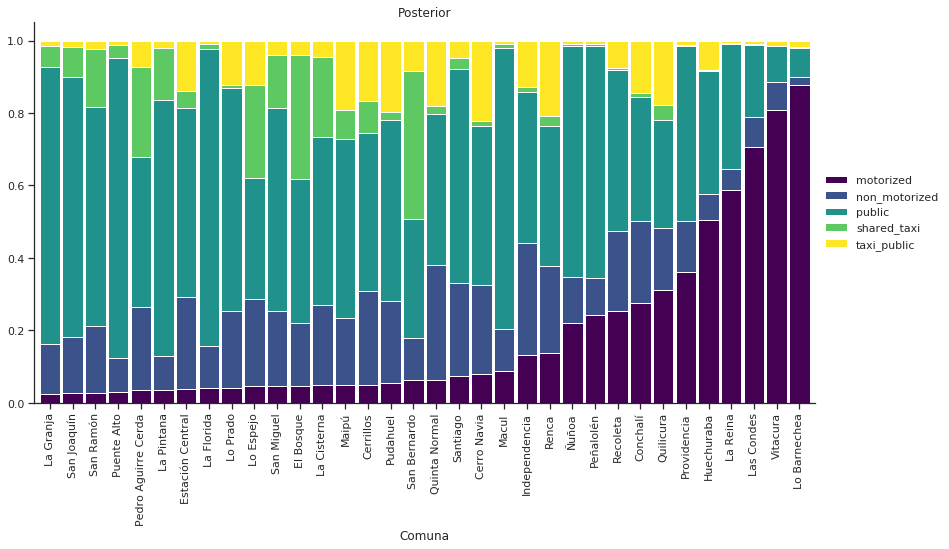

Actual period: morning_valley
Epoch 05 reached after 0.361 seconds, error: 2076.807695
Epoch 10 reached after 0.702 seconds, error: 2011.203825
Epoch 15 reached after 1.036 seconds, error: 1998.741739
Epoch 20 reached after 1.369 seconds, error: 1995.794877
Epoch 25 reached after 1.693 seconds, error: 1994.691369
Epoch 30 reached after 2.023 seconds, error: 1994.131766
Epoch 35 reached after 2.346 seconds, error: 1993.754969
Epoch 40 reached after 2.676 seconds, error: 1993.435616
Epoch 45 reached after 2.999 seconds, error: 1993.123685
Epoch 50 reached after 3.329 seconds, error: 1992.808690
Epoch 55 reached after 3.652 seconds, error: 1992.499555
Epoch 60 reached after 3.983 seconds, error: 1992.207253
Epoch 65 reached after 4.307 seconds, error: 1991.933442
Epoch 70 reached after 4.640 seconds, error: 1991.671024
Epoch 75 reached after 4.964 seconds, error: 1991.409508
Epoch 80 reached after 5.297 seconds, error: 1991.138986
Epoch 85 reached after 5.625 seconds, error: 1990.856519
E

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


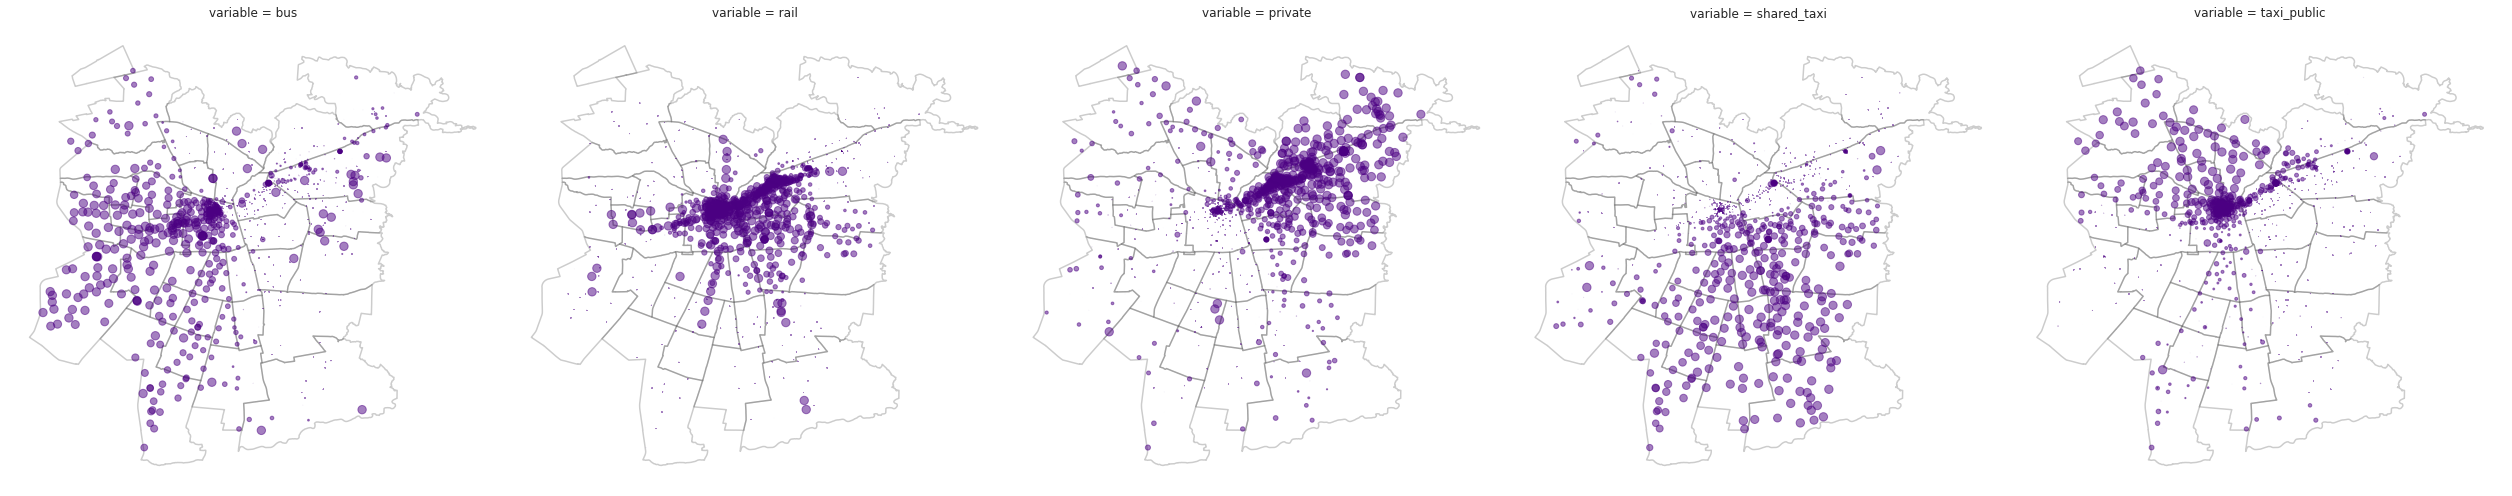

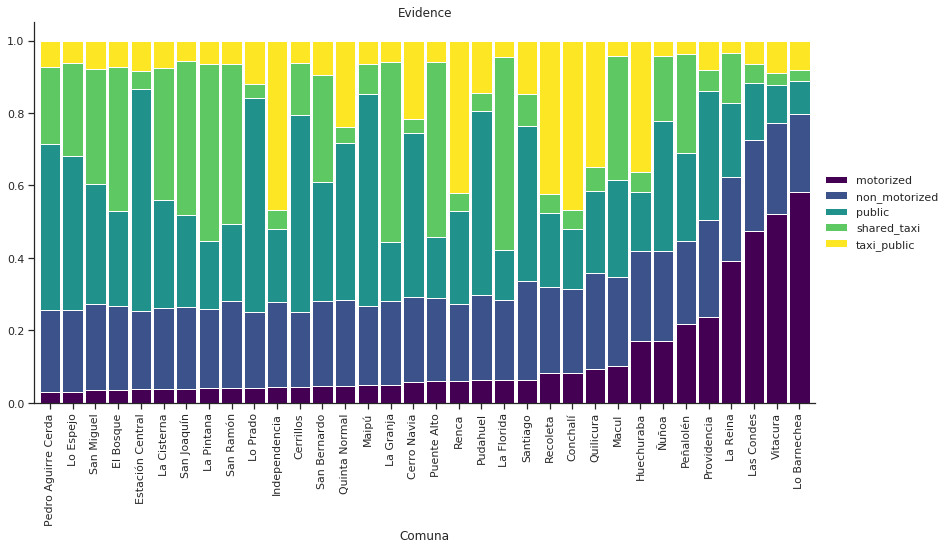

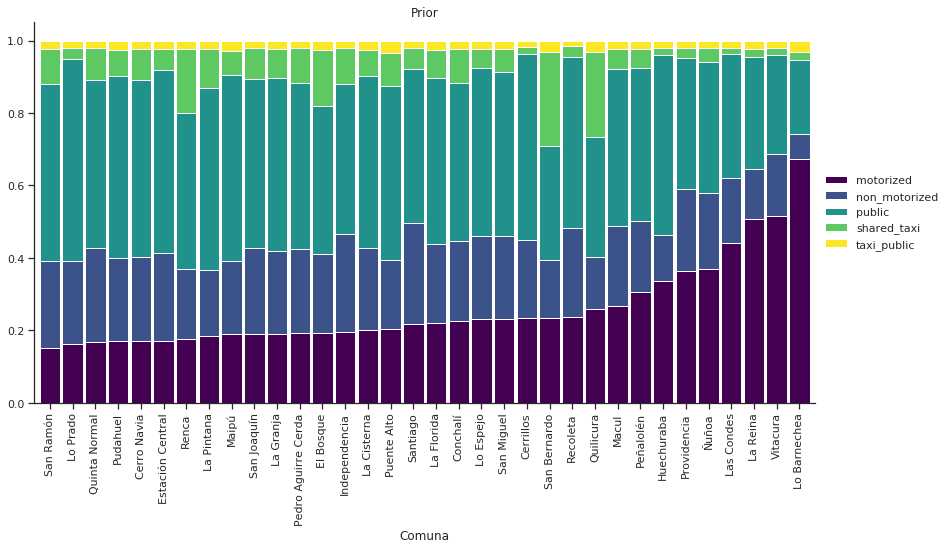

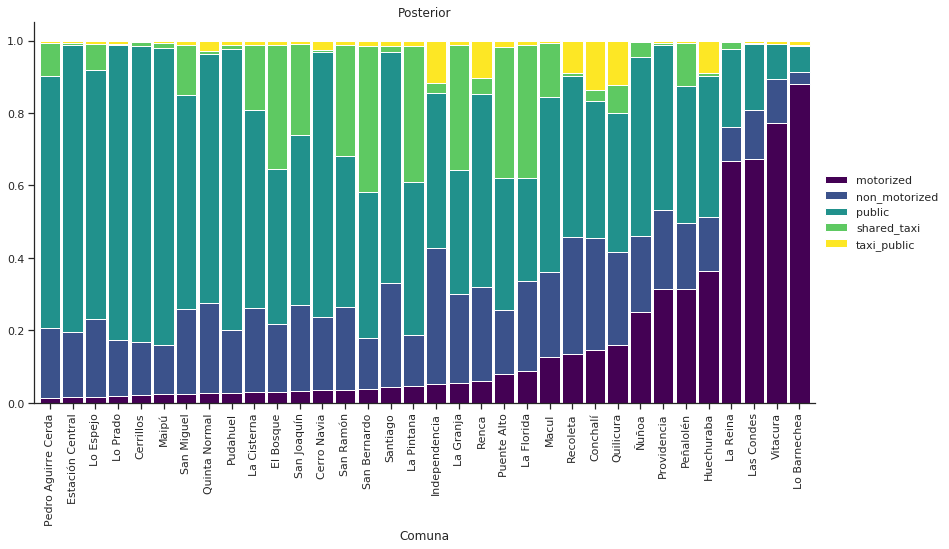

Actual period: night
Epoch 05 reached after 0.165 seconds, error: 1361.537424
Epoch 10 reached after 0.309 seconds, error: 1340.786752
Epoch 15 reached after 0.471 seconds, error: 1331.405356
Epoch 20 reached after 0.623 seconds, error: 1326.385900
Epoch 25 reached after 0.768 seconds, error: 1324.868999
Epoch 30 reached after 0.931 seconds, error: 1324.325475
Epoch 35 reached after 1.077 seconds, error: 1324.045471
Epoch 40 reached after 1.222 seconds, error: 1323.854642
Epoch 45 reached after 1.368 seconds, error: 1323.708882
Epoch 50 reached after 1.515 seconds, error: 1323.598726
Epoch 55 reached after 1.662 seconds, error: 1323.516168
Epoch 60 reached after 1.807 seconds, error: 1323.454836
Epoch 65 reached after 1.955 seconds, error: 1323.410035
Epoch 70 reached after 2.102 seconds, error: 1323.378666
Epoch 75 reached after 2.250 seconds, error: 1323.356084
Epoch 80 reached after 2.403 seconds, error: 1323.339349
Epoch 85 reached after 2.551 seconds, error: 1323.326633
Epoch 90 r

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


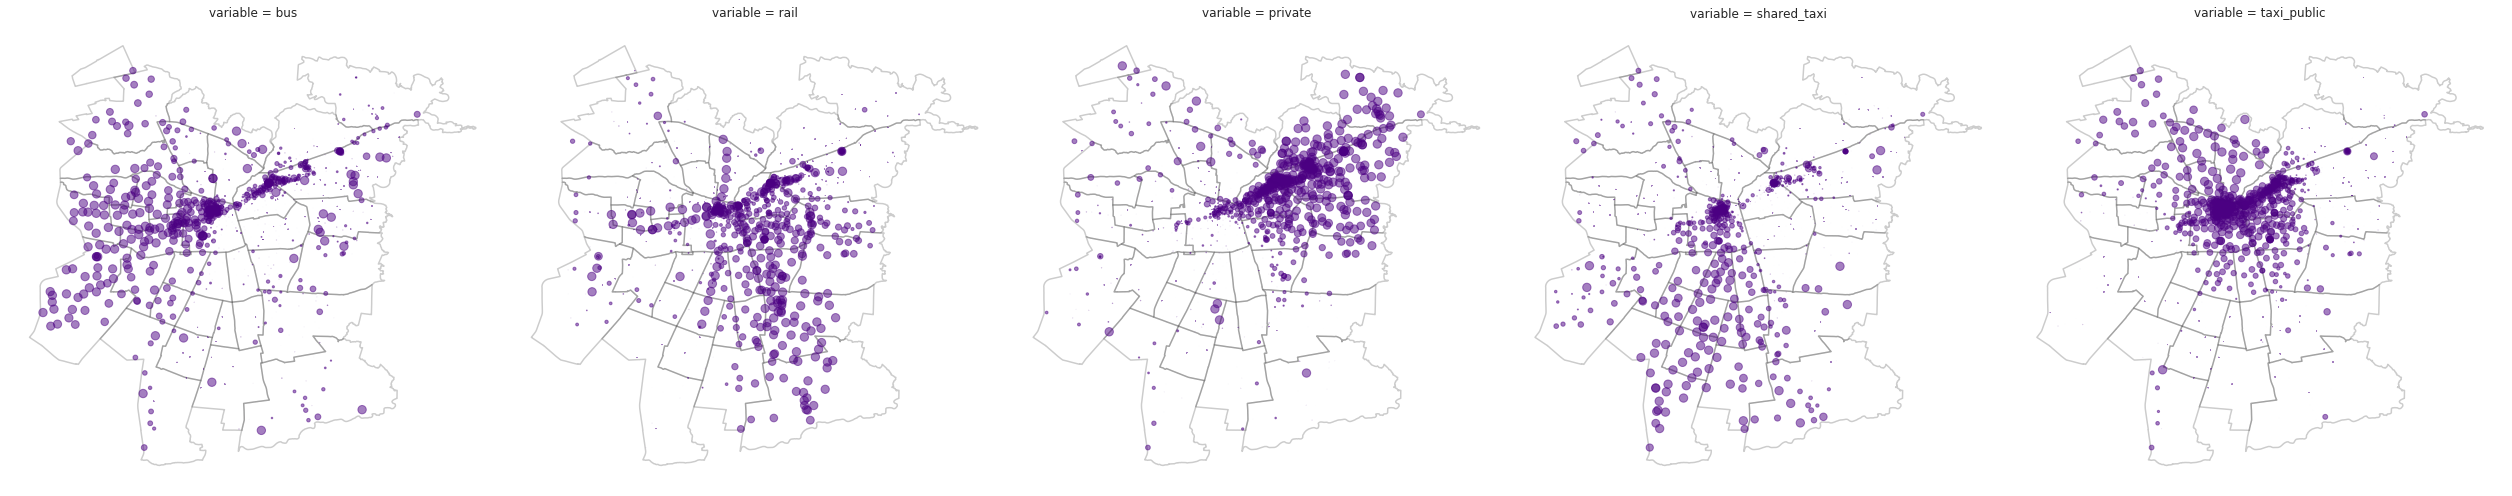

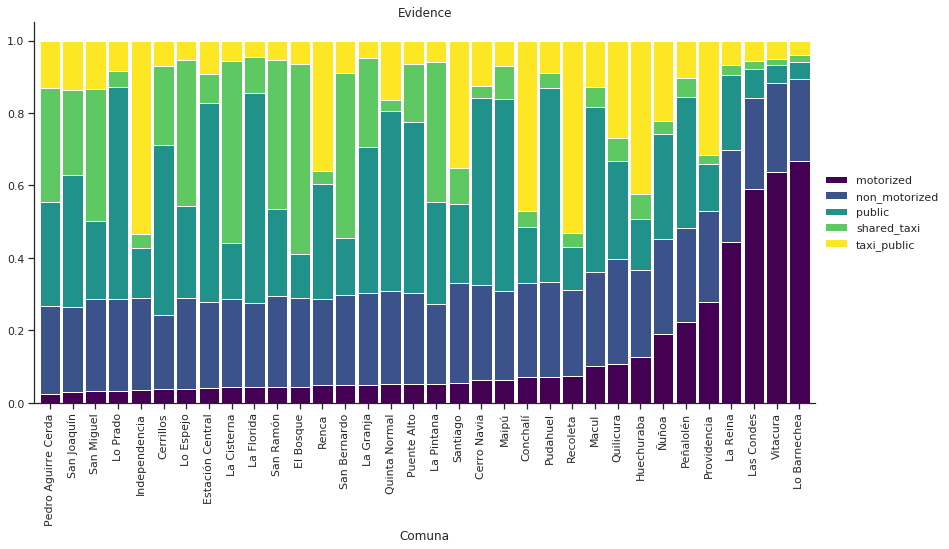

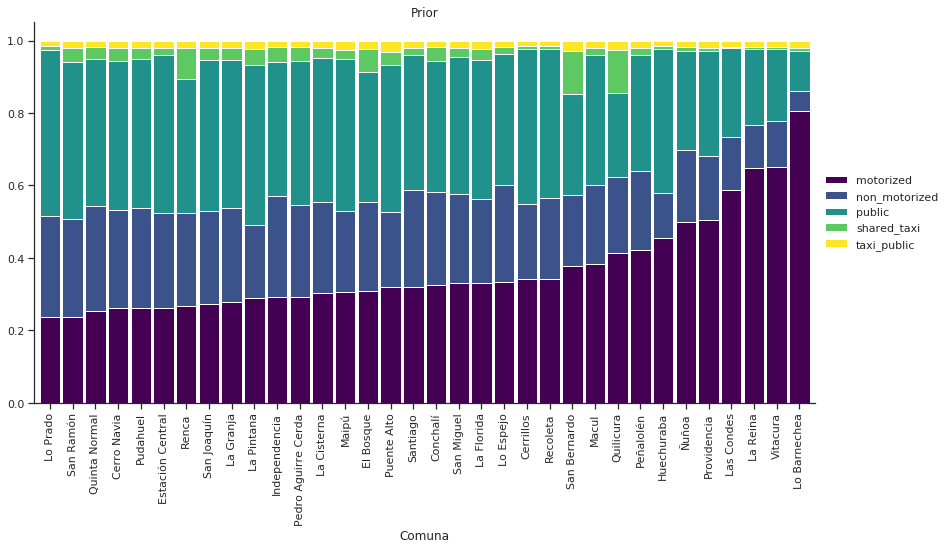

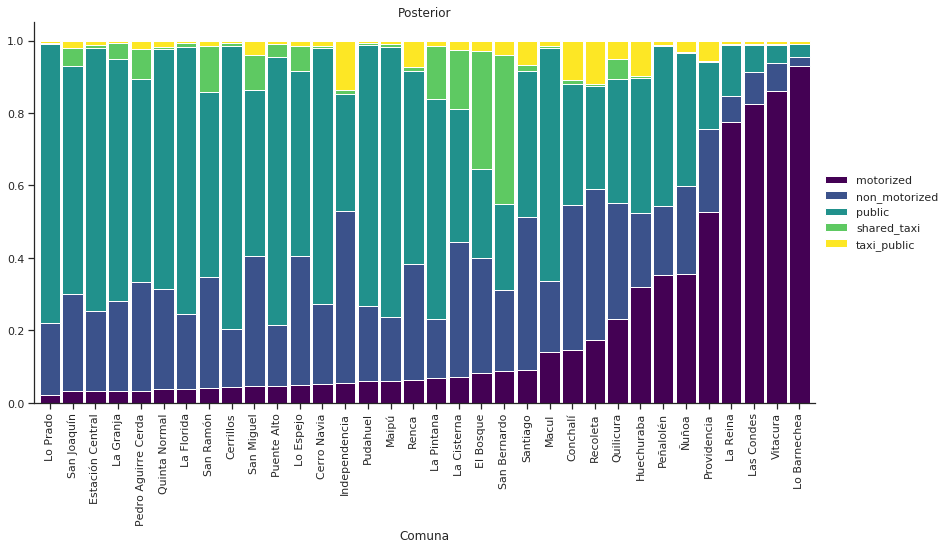

Actual period: night_valley
Epoch 05 reached after 0.170 seconds, error: 1408.954002
Epoch 10 reached after 0.326 seconds, error: 1379.798788
Epoch 15 reached after 0.485 seconds, error: 1373.356968
Epoch 20 reached after 0.648 seconds, error: 1371.649498
Epoch 25 reached after 0.808 seconds, error: 1370.818042
Epoch 30 reached after 0.970 seconds, error: 1370.398179
Epoch 35 reached after 1.127 seconds, error: 1370.138751
Epoch 40 reached after 1.284 seconds, error: 1369.958085
Epoch 45 reached after 1.441 seconds, error: 1369.830723
Epoch 50 reached after 1.599 seconds, error: 1369.739910
Epoch 55 reached after 1.757 seconds, error: 1369.682626
Epoch 60 reached after 1.917 seconds, error: 1369.644872
Epoch 65 reached after 2.079 seconds, error: 1369.618727
Epoch 70 reached after 2.244 seconds, error: 1369.601163
Epoch 75 reached after 2.407 seconds, error: 1369.589520
Epoch 80 reached after 2.572 seconds, error: 1369.581189
Epoch 85 reached after 2.736 seconds, error: 1369.574284
Epo

/home/vnavarro/.local/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/vnavarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


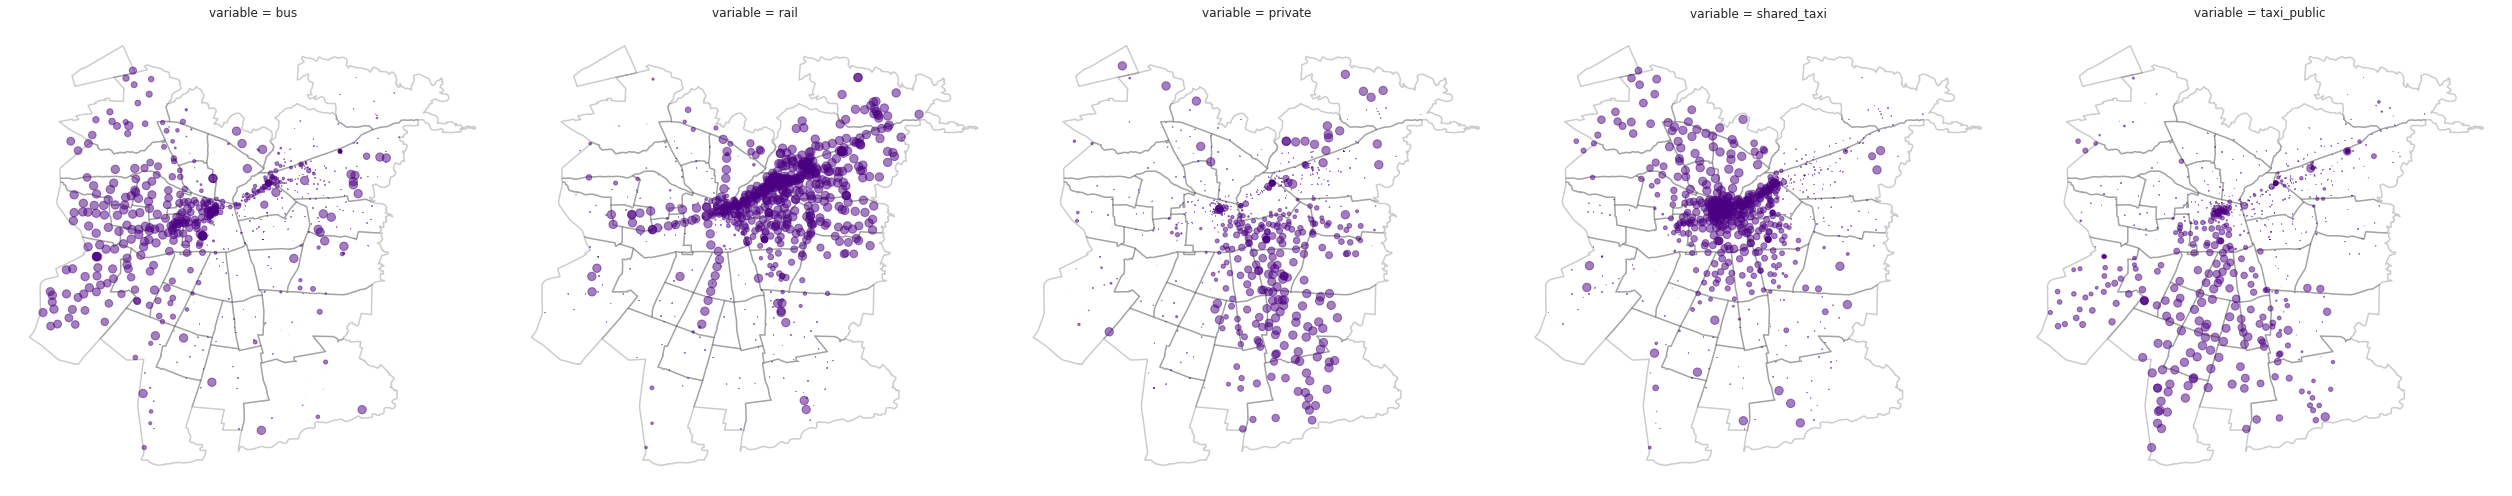

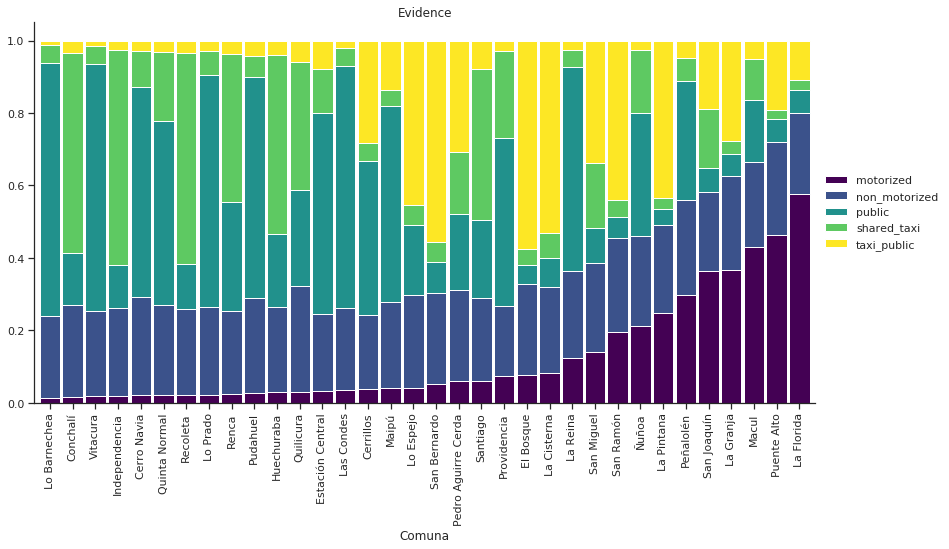

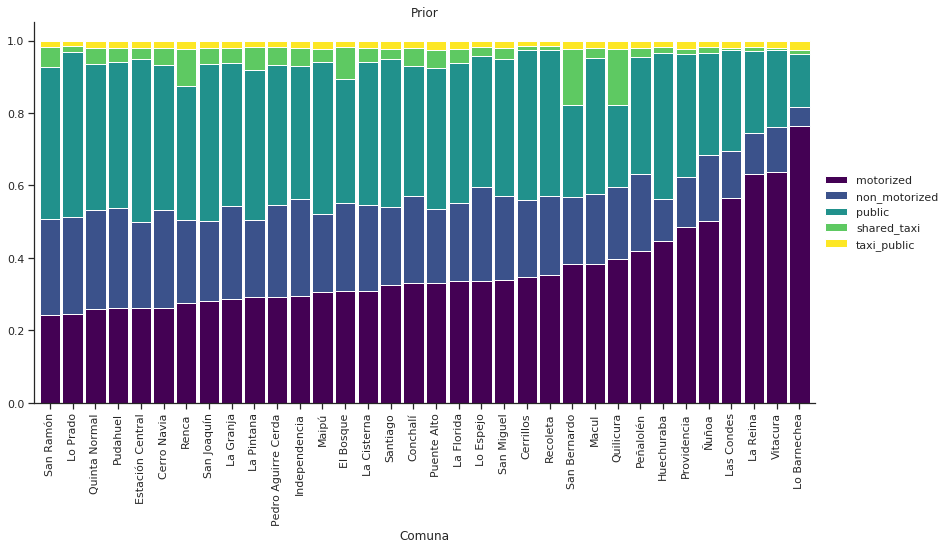

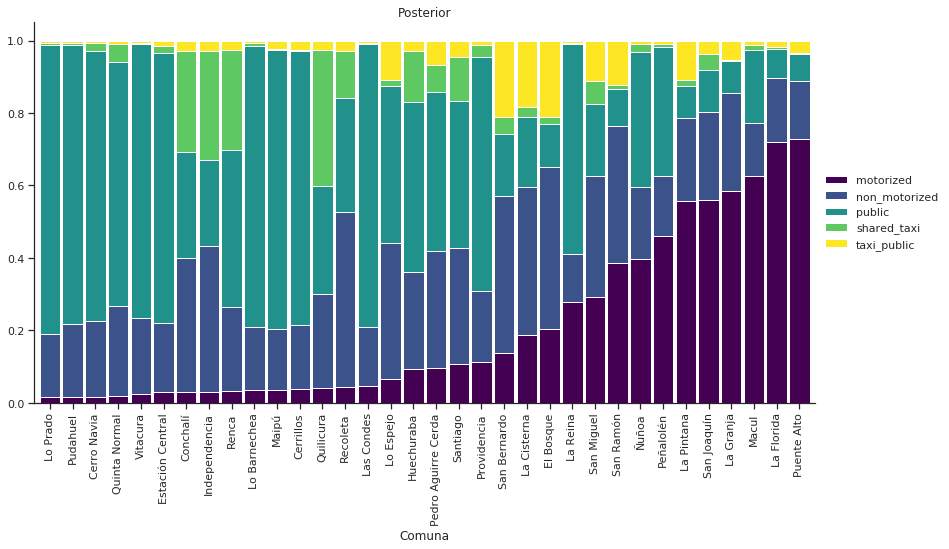

Done...


In [9]:
i=0
for period in periods:
    #if period!='afternoon_peak': break
    print("Actual period:", period)
    # work only on this period
    waypoint_periods = waypoint_index[waypoint_index.period == period]
    # we use a binary matrix this time! we are interested in routes, not in magnitudes
    to_factorize = csr_matrix(waypoints[waypoint_periods.index].T, copy=True)
    to_factorize[to_factorize > 0] = 1
    
    # these are the static values used to evaluate the prior from EOD
    zone_features = (waypoint_periods
        .join(zone_income, on='origin_zone', how='inner')
        .rename(columns={'mean_home_income': 'origin_income'})
        .join(zone_income, on='destination_zone', how='inner')
        .rename(columns={'mean_home_income': 'destination_income'})
        .join(zone_distances, on=['origin_zone', 'destination_zone'], how='inner')
        .join(zone_mindist.add_prefix('origen_'), on='origin_zone', how='inner')
        .join(zone_mindist.add_prefix('destino_'), on='destination_zone', how='inner')
        .pipe(lambda x: x[x['origin_zone']!=x['destination_zone']])
                    )
    
    # perform the factorization
    nmf = TSNMF(n_components=len(topic_ids), init='random', verbose=1, tol=1e-06, random_state=6, max_iter=500)
    W = nmf.fit_transform(to_factorize, labels)

    tower_mode = pd.DataFrame(normalize(W, norm='l1') , index=towers.index.tolist(), columns= labeled_keys.keys())
    tower_mode.index.name = 'tower'

    # plot the tower factorization for inspection
    sup_tower_components = (tower_mode
                            .reset_index()
                            .pipe(lambda x: pd.melt(x, id_vars='tower')))

    sup_scaler = MinMaxScaler(feature_range=(sup_min_bubble_size, sup_max_bubble_size))
    sup_scaler.fit(np.sqrt(sup_tower_components.value.values.reshape(-1, 1)))

    sup_geodf = gpd.GeoDataFrame(sup_tower_components.join(towers, on='tower'), crs={'init': 'epsg:4326'})
    g = sns.FacetGrid(data=sup_geodf, col='variable', height=7, aspect=1, sharex=False, sharey=False)
    for ax in g.axes.ravel():
        RM_map.boundary.plot(color='black', alpha=0.2, ax=ax)
    g.map_dataframe(plot_component, 'value', scaler=sup_scaler)

    # retrieve the zone-mode matrix
    flow_mode = (pd.DataFrame(nmf.components_.T , 
                              index=waypoint_periods.index, 
                              columns= labeled_keys.keys())
                 .join(waypoint_periods)
                 .set_index(['origin_zone', 'destination_zone'])
                 .drop(['index', 'period'], axis=1)
    )
    

    # estimate a probability for non motorized trips.
    # we use a logistic function. the 0.5 prob for non motorized trips is assigned at 200 meters.
    non_motorized_p = 1 - 1 / (1 + np.exp(-(zone_distances.loc[flow_mode.index].distance - 0.2)))
    non_motorized_p.name = 'non_motorized'

    # build the evidence matrix with with the zone-mode matrix and non-motorized probabilities
    flow_evidence = (flow_mode
                      .pipe(normalize_dataframe_rows)
                      .mul(1 - non_motorized_p.values, axis='rows')
                      .assign(non_motorized=non_motorized_p.values)
                      .assign(public=lambda x: x['bus'] + x['rail'])
                      .drop(['bus', 'rail'], axis=1)
                      .rename(columns={'private': 'motorized'})
                      [mnlogit_column_names]
    )

    # plot the evidence modal partition for inspection
    flow_evidence_trips = flow_evidence.mul(period_matrices.loc[period], axis='index')

    (flow_evidence_trips
     .join(zones.Comuna, on='origin_zone')
     .groupby('Comuna')
     .sum()
     .pipe(normalize_dataframe_rows)
     .sort_values('motorized')
     .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
    )
    plt.title('Evidence')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    sns.despine()

    # estimate the prior information using the EOD mnlogit model
    zone_priors = mnlogit.predict(zone_features.set_index(['origin_zone', 'destination_zone']))
    zone_priors.columns = mnlogit_column_names
    flow_priors = zone_priors.loc[flow_evidence.index]

    # plot the prior partition for inspection
    flow_prior_trips = flow_priors.mul(period_matrices.loc[period], axis='index')

    (flow_prior_trips
     .join(zones.Comuna, on='origin_zone')
     .groupby('Comuna')
     .sum()
     .pipe(normalize_dataframe_rows)
     .sort_values('motorized')
     .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
    )
    plt.title('Prior')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    sns.despine()

    # use bayes theorem to estimate the posterior modal partition
    denominator = flow_priors.mul(flow_evidence).sum(axis=1)
    flow_posteriors = flow_evidence.mul(flow_priors).div(denominator, axis='index')

    # plot the posterior partition for inspection
    flow_trips = flow_posteriors.mul(period_matrices.loc[period], axis='index')

    (flow_trips
     .join(zones.Comuna, on='origin_zone')
     .groupby('Comuna')
     .sum()
     .pipe(normalize_dataframe_rows)
     .sort_values('motorized')
     .plot(kind='bar', stacked=True, figsize=(14, 7), cmap='viridis', width=0.9, legend=False)
    )
    plt.title('Posterior')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
    sns.despine()

    # export data
    raw_tower_mode = pd.DataFrame(W , index=towers.index.tolist(), columns= labeled_keys.keys())
    raw_tower_mode.index.name = 'tower'
    raw_tower_mode.to_csv('2020_results/flow_model_{}_tower_mode.csv.gz'.format(period))

    flow_mode.to_csv('2020_results/flow_model_{}_zone_mode.csv.gz'.format(period))

    (flow_posteriors
     .reset_index()
     .assign(period=period)
     .to_json('2020_results/modal_partition_zones_{}.json.gz'.format(period), 
              compression='gzip', orient='records', lines=True)
    )
    # done!
    plt.show()
    i+=1
print("Done...")